In [1]:
from pyquery import PyQuery as pq
import requests
from tqdm import tqdm_notebook
from tqdm import tqdm_notebook as tqdm
from pyelasticsearch import ElasticSearch
import pandas as pd
from datetime import datetime, timedelta
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from time import sleep
from matplotlib import animation
from matplotlib import gridspec
from IPython.display import HTML
import json
import numpy as np

In [2]:
client = ElasticSearch("http://localhost:9201")

In [3]:
airdrops = requests.get("https://airdropalert.com/api/airdrops/list/past").json()

In [4]:
for a in airdrops:
    if a["start_date"]:
        a["start_time"] = datetime.strptime(a['start_date']['date'].split(".")[0], "%Y-%m-%d %H:%M:%S")

In [5]:
for a in tqdm_notebook(airdrops):
    if ("start_time" in a) and (a["start_time"]):
        start_date = a["start_time"]
        query = {
            "size": 1,
            "sort": [
                {"timestamp" : "desc"},
            ],
            "query": {
                "range": {
                    "timestamp": {
                        "lte": start_date
                    }
                }
            }
        }
    try:
        a["start_block"] = client.send_request("GET", ["ethereum-block", "b", "_search"], query, {})['hits']['hits'][0]["_source"]["number"]
    except:
        print(a["name"])

NEM
CLAMS
Ethereum Hardfork (CAHF)



In [70]:
def get_block_by_timestamp(timestamp):
    timestamp = datetime.strptime(timestamp, "%Y-%m-%d")
    query = {
        "size": 1,
        "sort": [
            {"timestamp" : "desc"},
        ],
        "query": {
            "range": {
                "timestamp": {
                    "lte": timestamp
                }
            }
        }
    }
    return client.send_request("GET", ["ethereum-block", "b", "_search"], query, {})['hits']['hits'][0]["_source"]["number"]

In [7]:
def find_prices(token):
    try:
        token_prices = client.search(index="ethereum-token-price", doc_type="price", size=2000, query="token:{} AND USD:[0.0001 TO *]".format(token))["hits"]["hits"]
        token_prices = [t["_source"] for t in token_prices]
        prices_df = pd.DataFrame()
        prices_df["USD"] = [t["USD"] for t in token_prices]
        prices_df["timestamp"] = [t["timestamp"] for t in token_prices]
        prices_df["block"] = prices_df["timestamp"].apply(get_block_by_timestamp)
        return prices_df    
    except:
        return None

In [77]:
def find_prices_cc(token):
    return requests.get("https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym=USD&limit=2000".format(token)).json()["Data"]

In [9]:
def find_name(address):
    document = pq("https://etherscan.io/address/{}".format(address))
    return document("font[title='NameTag']").text()

In [10]:
def find_contract(contract_name):
    document = pq("https://etherscan.io/searchHandler?term=" + contract_name)
    return document.text()

In [11]:
def find_token_name(address):
    document = pq("https://etherscan.io/address/{}".format(address))
    try:
        return document("#ContentPlaceHolder1_tr_tokeninfo a").text().split("(")[1][:-1]
    except:
        pass

In [12]:
def clean_contract(name):
    return name.replace("Exclusive Airdrop", "").strip()

In [13]:
def get_contract_address(string, name):
    array = string.split("\\t")
    for address in array:
        if address.startswith("0x"):
            contract_name = find_name(address)
            if name in contract_name:
                return address

In [14]:
for a in tqdm_notebook(airdrops):
    name = clean_contract(a["name"])
    a["contract_address"] = get_contract_address(find_contract(name), name)
    a["token_name"] = find_token_name(a["contract_address"])

In [16]:
json.dump(a, open("airdrops.json", "w"))

In [82]:
prices = {}
for a in tqdm_notebook(airdrops):
    prices[a["name"]] = find_prices_cc(a["token_name"])

In [102]:
for a in tqdm_notebook(airdrops):
    token_prices = [p for p in prices[a["name"]] if p["open"] > 0]
    if token_prices:
        x = token_prices[0]["time"]
        try:
            a["start_price"] = get_block_by_timestamp(datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))
        except:
            a["shit"] = True

In [85]:
def convert_prices_cc(prices):
    dataframe = pd.DataFrame([p for p in prices if p["open"] > 0])
    dataframe["block"] = dataframe["time"].apply(lambda x: get_block_by_timestamp(datetime.utcfromtimestamp(x).strftime('%Y-%m-%d')))
    return dataframe.sort_values("block")

In [103]:
good_airdrops = [a for a in airdrops if ("start_block" in a) and ("shit" not in a)]

In [104]:
very_good_airdrops = []
for a in good_airdrops:
    if (a["start_price"] < a["start_block"]) and (a["start_block"] < 5700000):
        very_good_airdrops.append(a)

In [105]:
len(very_good_airdrops)

133

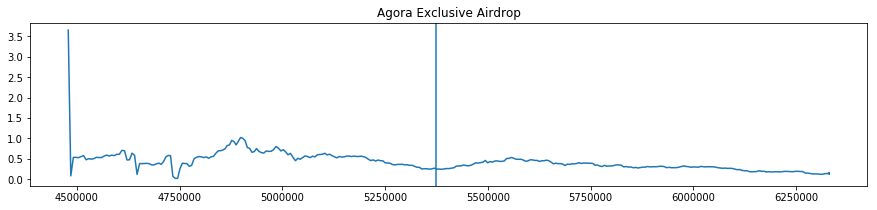

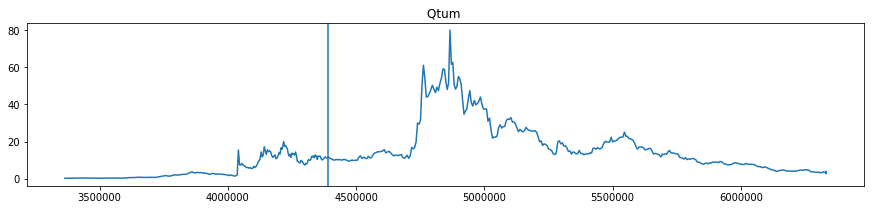

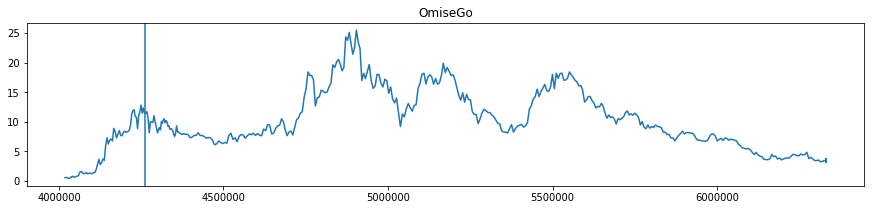

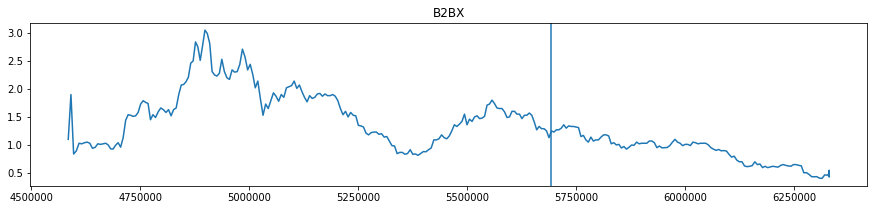

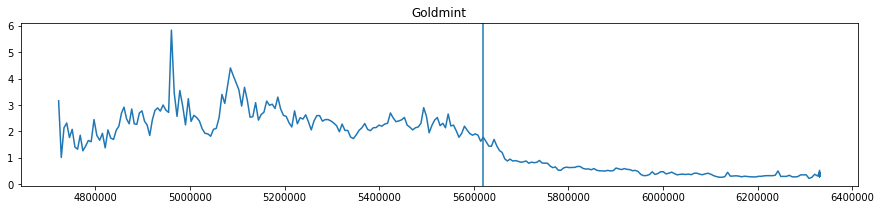

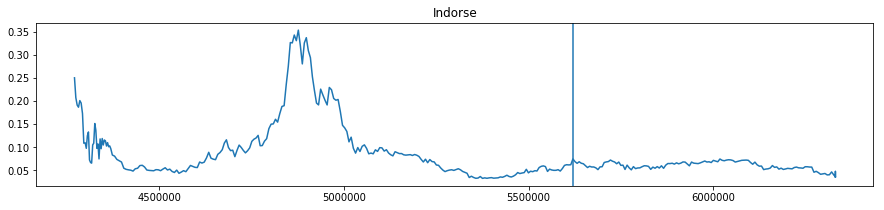

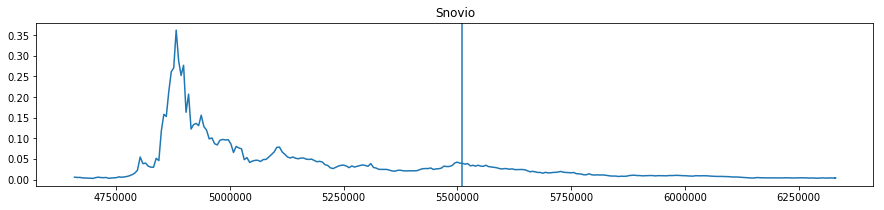

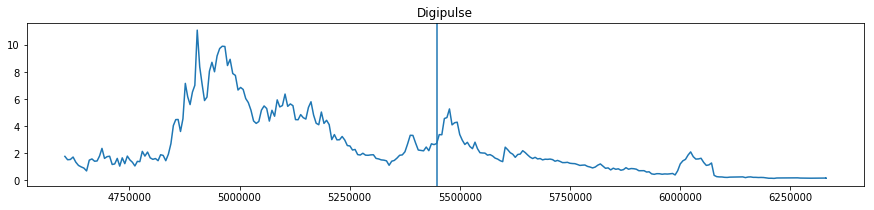

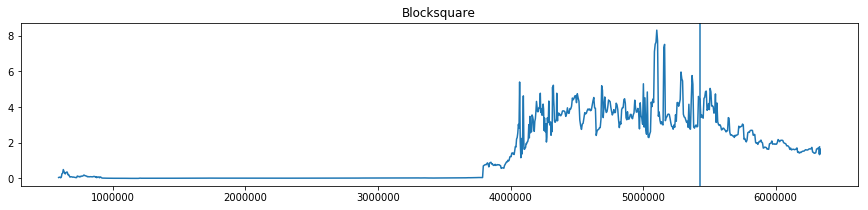

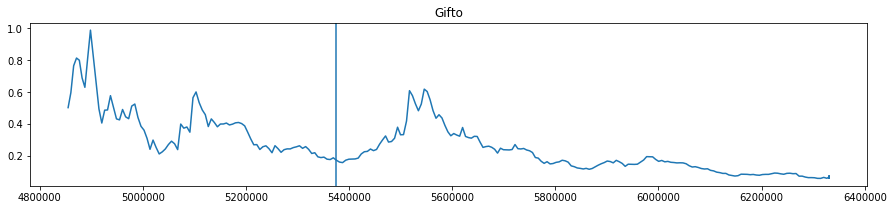

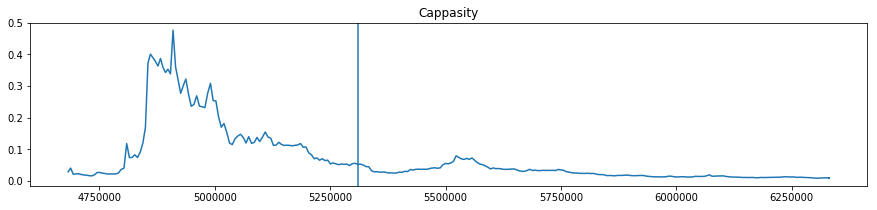

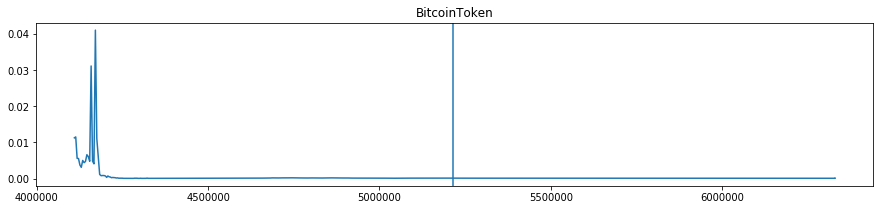

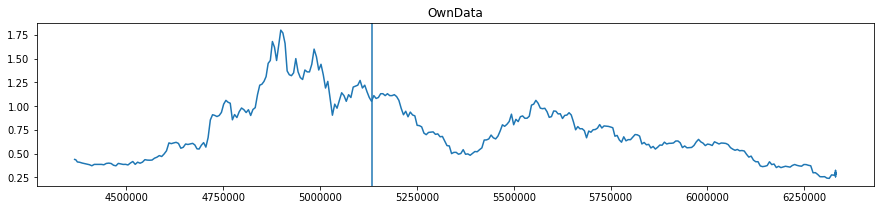

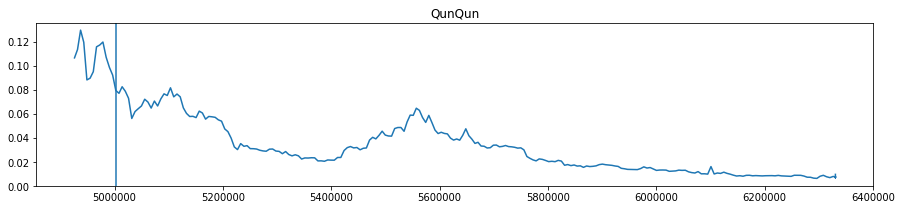

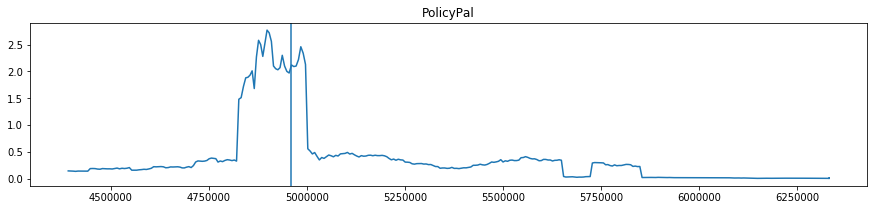

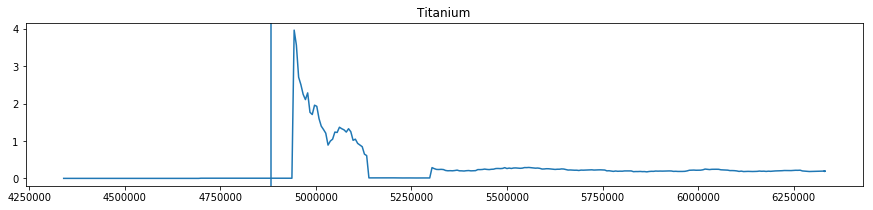

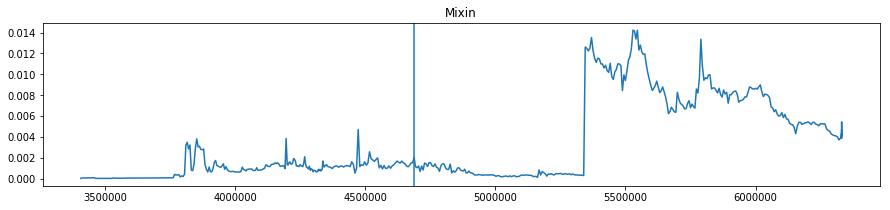

In [110]:
for a in tqdm_notebook(very_good_airdrops):
    if prices[a["name"]]:
        plt.figure(figsize=(15, 3))
        token_prices = convert_prices_cc(prices[a["name"]])
        a["all_prices"] = token_prices
        x = token_prices["block"]
        y = token_prices["open"]
        plt.plot(x, y)
        plt.axvline(a["start_block"])
        plt.title(a["name"])
        plt.show()

In [111]:
prepared_airdrops = [a for a in very_good_airdrops if "all_prices" in a]

In [117]:
[a["contract_address"] for a in prepared_airdrops]

['0x2f5e044ad4adac34c8d8df738fac7743eda1409c',
 '0x9a642d6b3368ddc662CA244bAdf32cDA716005BC',
 '0xd26114cd6EE289AccF82350c8d8487fedB8A0C07',
 '0x5d51fcced3114a8bb5e90cdd0f9d682bcbcc5393',
 '0x83cee9e086a77e492ee0bb93c2b0437ad6fdeccc',
 '0xf8e386eda857484f5a12e4b5daa9984e06e73705',
 '0xbdc5bac39dbe132b1e030e898ae3830017d7d969',
 '0xf6cfe53d6febaeea051f400ff5fc14f0cbbdaca1',
 '0x509A38b7a1cC0dcd83Aa9d06214663D9eC7c7F4a',
 '0xc5bbae50781be1669306b9e001eff57a2957b09d',
 '0x04f2e7221fdb1b52a68169b25793e51478ff0329',
 '0xdb8646f5b487b5dd979fac618350e85018f557d4',
 '0x170b275ced089fffaebfe927f445a350ed9160dc',
 '0x264dc2dedcdcbb897561a57cba5085ca416fb7b4',
 '0xfedae5642668f8636a11987ff386bfd215f942ee',
 '0xc7579bb99af590ec71c316e1ac4436c535039594',
 '0xa974c709cfb4566686553a20790685a47aceaa33']

In [146]:
BLOCK_GAP = 100000

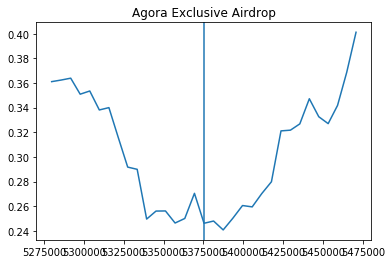

True


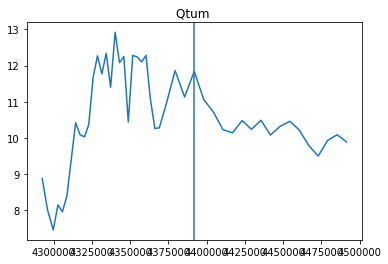

False


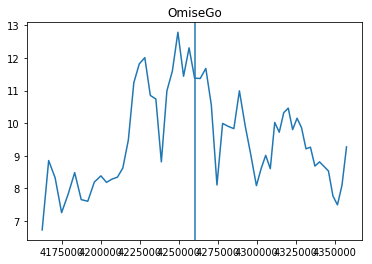

True


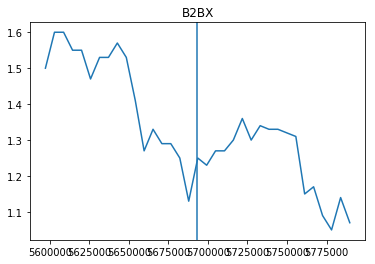

False


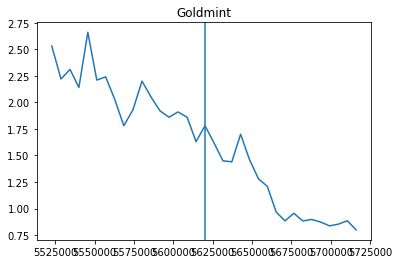

False


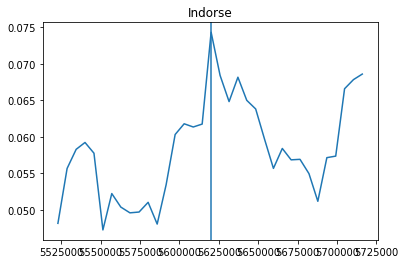

True


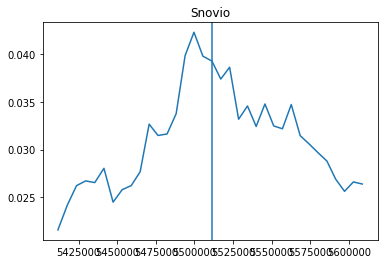

True


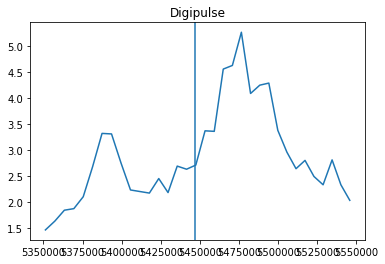

True


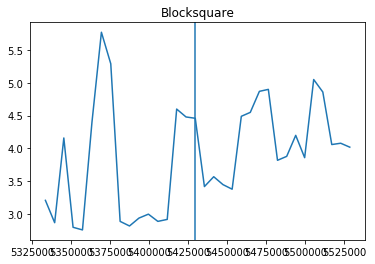

True


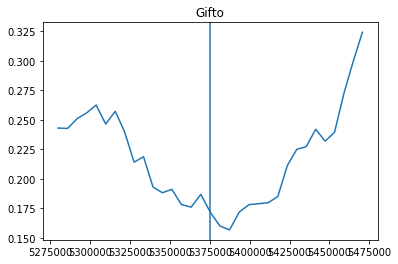

True


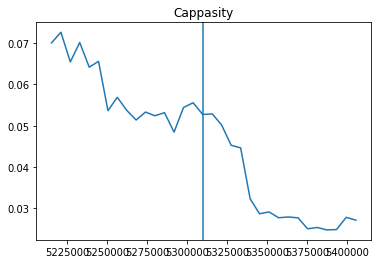

False


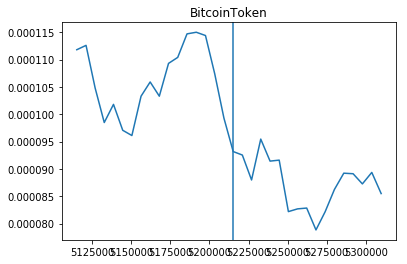

False


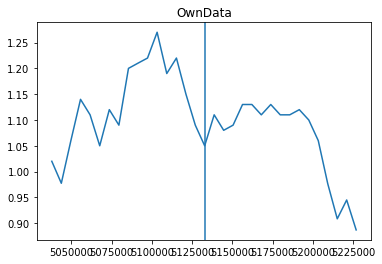

False


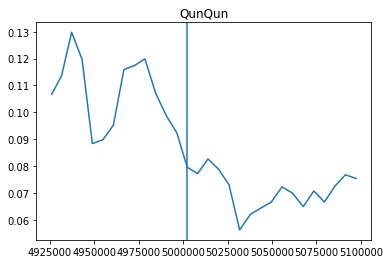

False


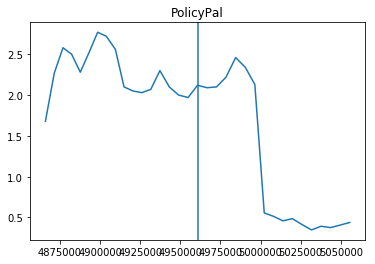

False


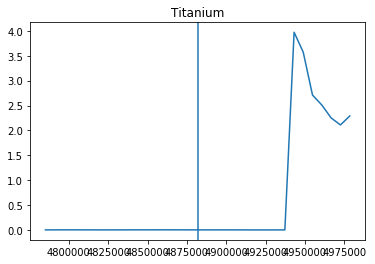

True


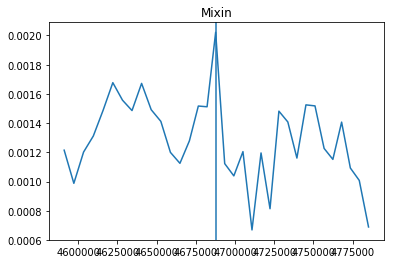

False


In [147]:
for airdrop in prepared_airdrops:
    airdrop_prices = airdrop["all_prices"]
    airdrop_prices = airdrop_prices[(airdrop_prices["block"] > airdrop["start_block"] - BLOCK_GAP) & (airdrop_prices["block"] < airdrop["start_block"] + BLOCK_GAP)]
    x = airdrop_prices["block"]
    y = airdrop_prices["open"]
    plt.plot(x, y)
    plt.axvline(airdrop["start_block"])
    plt.title(airdrop["name"])
    plt.show()
    airdrop["class"] = (airdrop_prices[airdrop_prices["block"] > airdrop["start_block"]]["open"].sum() - airdrop_prices[airdrop_prices["block"] < airdrop["start_block"]]["open"].sum()) > 0
    print(airdrop["class"])

In [163]:
jsons = [{
    "prices": {k: v for k, v in zip(a["all_prices"]["block"], a["all_prices"]["open"])},
    "start_block": a["start_block"],
    "contract": a["contract_address"].lower(),
    "name": a["name"],
    "class": int(a["class"])
    
} for a in prepared_airdrops]

In [164]:
json.dump(jsons, open("prepared_airdrops.json", "w"))

- Добавить vinchain, найти список инвесторов

In [ ]:
transactions = client.search(index="ethereum-internal-transaction", doc_type="tx", query="to:0xf3e014fe81267870624132ef3a646b8e83853a96")